In [2]:
# fnirs_data_training.py
# 2/26/2025 - 3/10/2025
# Mady Davis-Troller
# to learn how to do fnirs preprocessing 
#################################

# 1 import packages
# 2 load in data 
# 3 visualize time courses, sensors
# 4 convert intensity to optical density
# 5 check scalp coupling index (SCI), mark bad channels ___________________ this where we stopped
# 6 apply TDDR (temporal derivative distribution repair), remove movement artifact
# 7 high-pass filter the data, low cut off of .01Hz
# 8 apply short channel regression/enhancement
# 9 low-pass filter the data
# 10 apply the MBLL modified beer lambert law, units of change in micromolar

#################################

# https://mne.tools/1.8/auto_tutorials/preprocessing/70_fnirs_processing.html

In [ ]:
# 1 import packages
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np

import mne

In [4]:
# 2 load in data 
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_data_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()

Using default location ~/mne_data for fnirs_motor...
Creating /Users/mdavistr/mne_data


100%|█████████████████████████████████████| 17.9M/17.9M [00:00<00:00, 11.6GB/s]
Untarring contents of '/Users/mdavistr/mne_data/MNE-fNIRS-motor-data.tgz' to '/Users/mdavistr/mne_data'


Attempting to create new mne-python configuration file:
/Users/mdavistr/.mne/mne-python.json
Download complete in 09s (17.1 MB)
Loading /Users/mdavistr/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


<RawNIRX | Participant-1, 56 x 23239 (2974.6 s), ~10.0 MiB, data loaded>

In [ ]:
#annotations for markers 
raw_intensity.annotations.set_durations(5)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)

In [ ]:
# 3 visualize time courses, sensors

#for viewing data of brain sensors overlaid on head

subjects_dir = mne.datasets.sample.data_path() / "subjects"
#will be set to our subject directory

brain = mne.viz.Brain(
    "fsaverage", subjects_dir=subjects_dir, background="w", cortex="0.5"
)
brain.add_sensors(
    raw_intensity.info,
    trans="fsaverage",
    fnirs=["channels", "pairs", "sources", "detectors"],
)
brain.show_view(azimuth=20, elevation=60, distance=400)

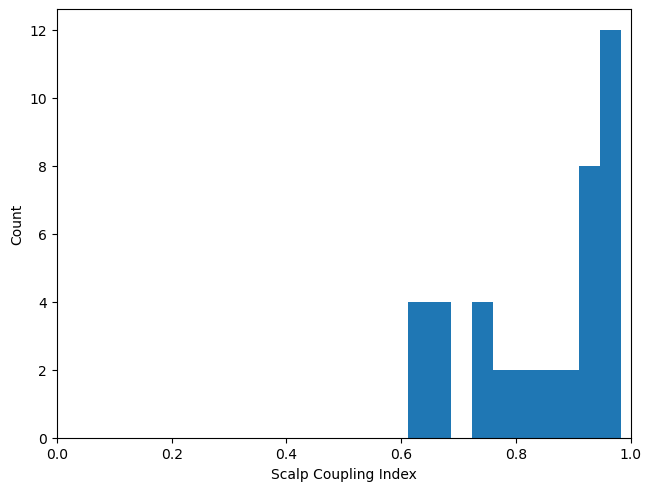

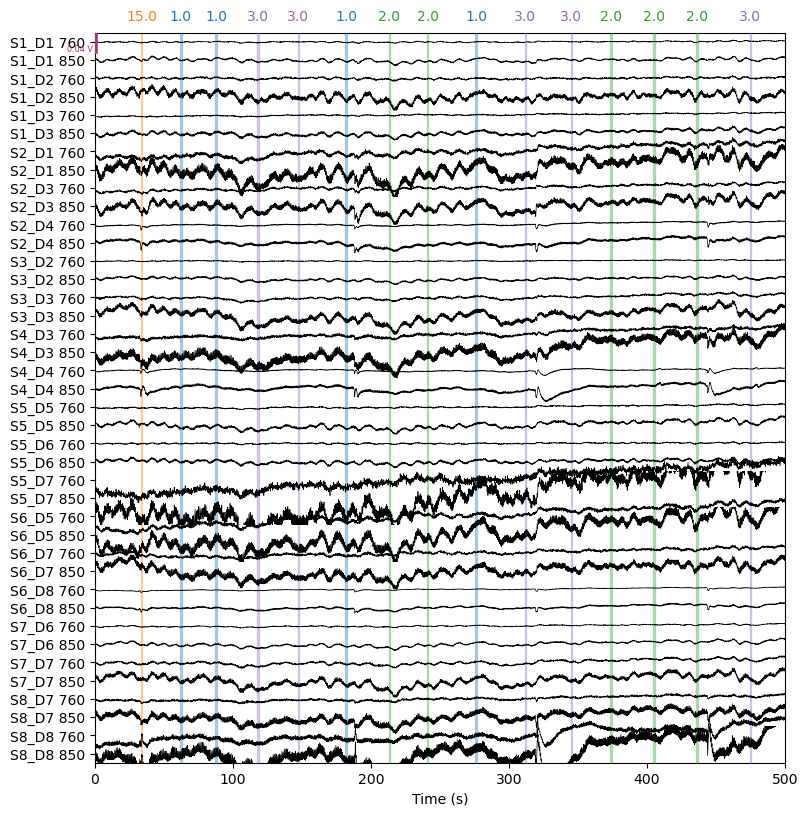

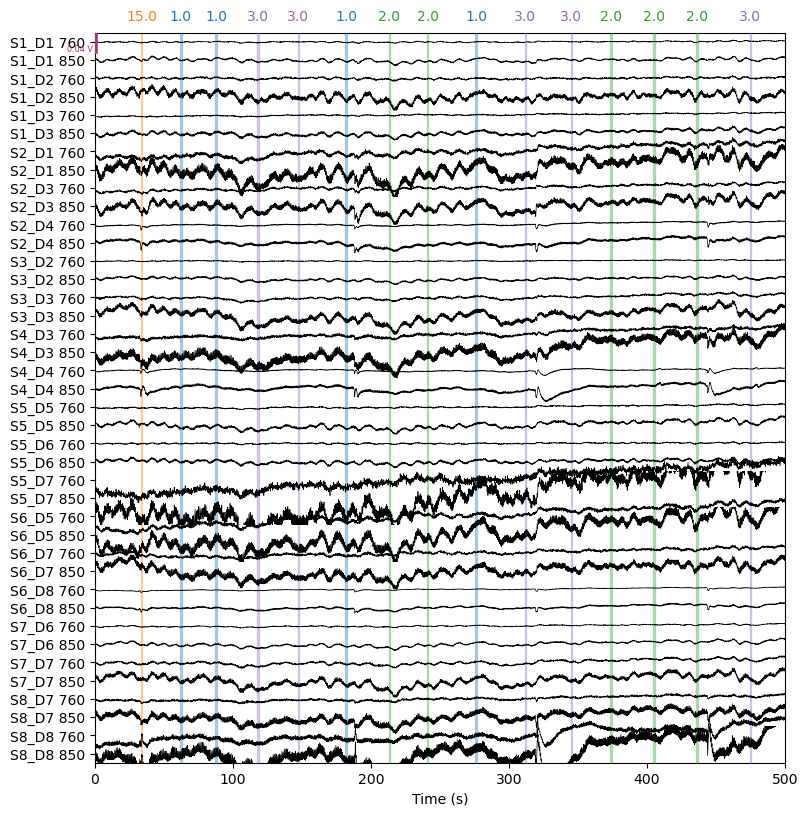

In [16]:
# 4 convert intensity to optical density

#find changes in deoxy and oxy blood
#modified Beer Lambert Law

picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks=picks
)
raw_intensity.pick(picks[dists > 0.01])
raw_intensity.plot(
    n_channels=len(raw_intensity.ch_names), duration=500, show_scrollbars=False
)

In [14]:
# 4 convert intensity to optical density 
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
#raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)

In [12]:
# 5 check scalp coupling index (SCI), mark bad channels
#check data at channel level, SCI at .8 or higher
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots(layout="constrained")
ax.hist(sci)
ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5)) # will set threshold for what data is considered bad

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

In [ ]:
# 6 applied TDDR
raw_tddr = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od.copy(), *, verbose=None)

In [ ]:
# 7 high pass filter the data, keep high frq info and reject low frq info by defining boundaries

raw_od_unfiltered = raw_tddr.copy()
raw_od_hfiltered = raw_tddr.copy()
raw_od_hfiltered.filter(l_freq = 0.01, h_freq = None, h_trans_bandwidth = None, l_trans_bandwidth = 0.01/2, 
                         method = 'iir', phase = 'zero') #band pass filter, need to decide filter cutoffs (0.01, 0.3), iir is a filter for time series
for when, _raw in dict(Before=raw_od_unfiltered, After=raw_od_hfiltered).items():
    fig = _raw.compute_psd().plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{when} high-pass-filtering", weight="bold", size="x-large")

In [ ]:
# 8 short channel regression

raw_od_short = mne_nirs.signal_enhancement.short_channel_regression(raw_od_hfiltered, max_dist=0.01)

In [ ]:
# 9 low pass filters

raw_od_bpfiltered = raw_od_short.copy() #bp = band pass
raw_od_bpfiltered.filter(l_freq = 0.01, h_freq = None, h_trans_bandwidth = None, l_trans_bandwidth = 0.01/2, 
                         method = 'iir', phase = 'zero') #band pass filter, need to decide filter cutoffs (0.01, 0.3), iir is a filter for time series
for when, _raw in dict(Before=raw_od_short, After=raw_od_bpfiltered).items():
    fig = _raw.compute_psd().plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{when} low-pass-filtering", weight="bold", size="x-large")

In [ ]:
# 10 apply beer_lambert_law and get long/short channels

#raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1) #we don't like this ppf (partial pathlength factor)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_bpfiltered.copy()) # this one we do, better representation of the vasculature that we're interested in 
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=500, show_scrollbars=False)

raw_haemo_long = get_long_channels(raw_haemo.copy())
raw_haemo_short = get_short_channels(raw_haemo.copy())

In [ ]:
# at the very end we will be in the change in concentration in micromolar 